In [1]:
import pandas as pd
import os

# data stored
data_path = '/Users/smallina/Desktop/Stanford/Data'
train_data_path = os.path.join(data_path, 'cars_train/')
test_data_path = os.path.join(data_path, 'cars_test/')
train_labels_path = os.path.join(data_path, 'anno_train.csv')
test_labels_path = os.path.join(data_path, 'anno_test.csv')

# annotate columns
anno_columns = ['image', 'x1', 'y1', 'x2', 'y2', 'car_model']

# load data into csv file
train_df = pd.read_csv(train_labels_path, header=None, names=anno_columns)
test_df = pd.read_csv(test_labels_path, header=None, names=anno_columns)

# print 
print(train_df.head())
print(test_df.head())

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


       image   x1   y1    x2    y2  car_model
0  00001.jpg   39  116   569   375         14
1  00002.jpg   36  116   868   587          3
2  00003.jpg   85  109   601   381         91
3  00004.jpg  621  393  1484  1096        134
4  00005.jpg   14   36   133    99        106
       image   x1   y1   x2   y2  car_model
0  00001.jpg   30   52  246  147        181
1  00002.jpg  100   19  576  203        103
2  00003.jpg   51  105  968  659        145
3  00004.jpg   67   84  581  407        187
4  00005.jpg  140  151  593  339        185


In [3]:
def load_image(img_path, target_size=(224, 224)):
    """Loads and preprocesses an image."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

def preprocess_data(df, img_dir):
    """Processes the dataframe and returns image paths with labels."""
    data_list = []
    for index, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image'])  
        label = row['car_model']
        data_list.append((label, img_path))
    return data_list

train_data = preprocess_data(train_df, train_data_path)
test_data = preprocess_data(test_df, test_data_path)

print("Loaded train data:", len(train_data))
print("Loaded test data:", len(test_data))

total_data = train_data + test_data
print("Loaded total_data:", len(total_data))


Loaded train data: 8144
Loaded test data: 8041
Loaded total_data: 16185


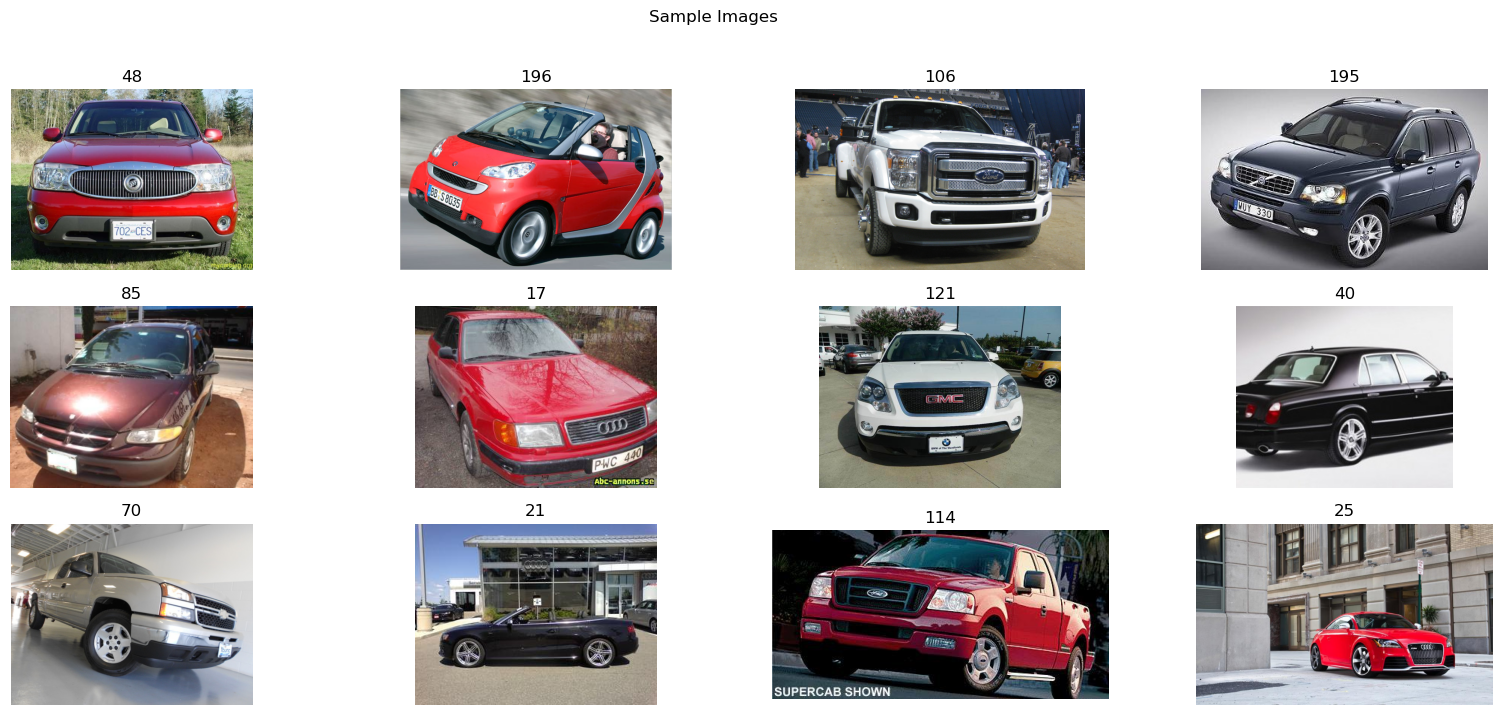

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_samples = np.random.randint(0,high=len(total_data)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(total_data[img_idx][0])
    # Read image
    image = cv2.imread(total_data[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

In [5]:
def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0],
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })

  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

In [ ]:
compute_dataset_metrics(total_data)

In [6]:
import random
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

train_x = [os.path.join(train_data_path, img) for img in train_df['image'].values]
train_y = train_df['car_model'].values 

test_x = [os.path.join(test_data_path, img) for img in test_df['image'].values]
test_y = test_df['car_model'].values  


split_idx = int(len(train_x) * 0.8)
validate_x = train_x[split_idx:]
validate_y = train_y[split_idx:]
train_x = train_x[:split_idx]
train_y = train_y[:split_idx]


label2index = {label: idx for idx, label in enumerate(sorted(set(train_y)))}
index2label = {idx: label for label, idx in label2index.items()}


num_classes = len(label2index)

class CarDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label2index[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Combine train and test data into total_data
total_x = train_x + test_x
total_y = np.concatenate([train_y, test_y])

# Shuffle the data
combined = list(zip(total_x, total_y))
random.shuffle(combined)
total_x, total_y = zip(*combined)

# Calculate split indices
train_split_idx = int(0.8 * len(total_x))
val_split_idx = int(0.9 * len(total_x))

# Split the data
train_x = total_x[:train_split_idx]
train_y = total_y[:train_split_idx]

validate_x = total_x[train_split_idx:val_split_idx]
validate_y = total_y[train_split_idx:val_split_idx]

test_x = total_x[val_split_idx:]
test_y = total_y[val_split_idx:]

# Create datasets with updated splits
train_dataset = CarDataset(train_x, train_y, transform=image_transforms['train'])
val_dataset = CarDataset(validate_x, validate_y, transform=image_transforms['val'])
test_dataset = CarDataset(test_x, test_y, transform=image_transforms['test'])

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# Verify with a single batch
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [7]:
import json
import time

class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

experiment_name = None

def create_experiment():
    global experiment_name
    experiment_name = "experiment_" + str(int(time.time()))

    # Create experiment folder
    if not os.path.exists(experiment_name):
        os.mkdir(experiment_name)

def save_model(model, model_name="model01"):
    # Save the entire model (structure + weights)
    torch.save(model.state_dict(), os.path.join(experiment_name, model_name + ".pth"))

def get_model_size(model_name="model01"):
    model_size = os.stat(os.path.join(experiment_name, model_name + ".pth")).st_size
    return model_size

def evaluate_save_model(model, test_loader, model_train_history, execution_time, learning_rate, batch_size, epochs, optimizer, save=True, device="cpu"):

    num_epochs = len(model_train_history["loss"])
    fig = plt.figure(figsize=(15, 5))


    axs = fig.add_subplot(1, 2, 1)
    axs.set_title('Loss')
    for metric in ["loss", "val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()


    axs = fig.add_subplot(1, 2, 2)
    axs.set_title('Accuracy')
    for metric in ["accuracy", "val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()


    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss() 

    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_test_loss = test_loss / len(test_loader)

    evaluation_results = {"loss": avg_test_loss, "accuracy": accuracy}
    print(evaluation_results)

    if save:
        # Save model
        save_model(model, model_name=model.__class__.__name__)
        model_size = get_model_size(model_name=model.__class__.__name__)

        # Save model history
        with open(os.path.join(experiment_name, model.__class__.__name__ + "_train_history.json"), "w") as json_file:
            json.dump(model_train_history, json_file, cls=JsonEncoder)

        trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
        non_trainable_parameters = sum(p.numel() for p in model.parameters() if not p.requires_grad)

        # Save model metrics
        metrics = {
            "trainable_parameters": trainable_parameters,
            "execution_time": execution_time,
            "loss": evaluation_results["loss"],
            "accuracy": evaluation_results["accuracy"],
            "model_size": model_size,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "epochs": epochs,
            "optimizer": type(optimizer).__name__
        }
        with open(os.path.join(experiment_name, model.__class__.__name__ + "_model_metrics.json"), "w") as json_file:
            json.dump(metrics, json_file, cls=JsonEncoder)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

num_classes = len(label2index)


model = models.resnet18(pretrained=True)  


model.fc = nn.Linear(512, num_classes)


for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  
criterion = nn.CrossEntropyLoss()


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, targets)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:  
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        print(f'Train Accuracy: {train_acc:.2f}%')

        
        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=25)

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch [1/25], Batch [0/364], Loss: 5.7860
Epoch [1/25], Batch [10/364], Loss: 5.3610
Epoch [1/25], Batch [20/364], Loss: 5.4324
Epoch [1/25], Batch [30/364], Loss: 5.4306
Epoch [1/25], Batch [40/364], Loss: 5.4099
Epoch [1/25], Batch [50/364], Loss: 5.4211
Epoch [1/25], Batch [60/364], Loss: 5.3122
Epoch [1/25], Batch [70/364], Loss: 5.4286
Epoch [1/25], Batch [80/364], Loss: 5.1934
Epoch [1/25], Batch [90/364], Loss: 5.3017
Epoch [1/25], Batch [100/364], Loss: 5.4094
Epoch [1/25], Batch [110/364], Loss: 5.2205
Epoch [1/25], Batch [120/364], Loss: 5.2055
Epoch [1/25], Batch [130/364], Loss: 5.1223
Epoch [1/25], Batch [140/364], Loss: 5.2904
Epoch [1/25], Batch [150/364], Loss: 5.3265
Epoch [1/25], Batch [160/364], Loss: 5.2814
Epoch [1/25],